# DS-GA 1011 Lab 8 Neural Machine Translation with Seq2Seq model and Attention

Adapted from the PyTorch tutorials (https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

In this lab we will be teaching a neural network to translate from French to English.
::

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

This is made possible by the simple but powerful idea of the `sequence
to sequence network <http://arxiv.org/abs/1409.3215>`__, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.


To improve upon this model we'll use an `attention
mechanism <https://arxiv.org/abs/1409.0473>`__, which lets the decoder
learn to focus over a specific range of the input sequence.



In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cuda')

## Loading Data

Download the data from https://download.pytorch.org/tutorial/data.zip and unzip the file in the location of the notebook.
    
We'll use data/eng-fra.txt where each line in the file is a tab separated pair of English and French word sequence:

    I am cold.    J'ai froid.


## Preprocess Data

We'll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called Lang which has word → index (word2index) and index → word (index2word) dictionaries, as well as a count of each word word2count to use to later replace rare words.

In [3]:
PAD_token = 0
SOS_token = 1
EOS_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "<pad>", 1: "SOS", 2: "EOS"}
        self.n_words = 3  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split lines into pairs. The files are all English → Other Language, so if we want to translate from Other Language → English I added the reverse flag to reverse the pairs.

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4490
eng 2926
['tu es en train d effrayer les enfants .', 'you re scaring the kids .']


In [9]:
a = [1,2,3]
b = [4]
a+b

[1, 2, 3, 4]

In [33]:
count1 = 0
for se in data_source:
    if len(se)>count1:
        count1 = len(se)

In [34]:
count1

10

In [35]:
count2 = 0
for se in data_target:
    if len(se)>count2:
        count2 = len(se)
        
count2

11

In [8]:
data_source = []
data_target = []

for pair in pairs:
    se0 = [input_lang.word2index[word] for word in pair[0].split(' ')]
    se0.append(EOS_token)
    se1 = [SOS_token] + [output_lang.word2index[word] for word in pair[1].split(' ')] + [EOS_token]
    data_source.append(se0)
    data_target.append(se1)

In [9]:
len(data_source), len(data_target)

(10853, 10853)

In [10]:
from torch.utils.data import Dataset
import numpy as np

class TranslateDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_source, data_target):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.source, self.target = data_source, data_target
        assert (len(self.source)==len(self.target))

    def __len__(self):
        return len(self.source)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        return [self.source[key], len(self.source[key]), self.target[key], len(self.target[key])]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    source_list = []
    target_list = []
    length_list = []

    for datum in batch:
        length_list.append(max(datum[1], datum[3]))
    # padding
    MAX_WORD_LENGTH = 11
    #max_length = max(length_list)
    for datum in batch:
        padded_source = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_WORD_LENGTH-len(datum[0]))),
                                mode="constant", constant_values=0)
        padded_target = np.pad(np.array(datum[2]),
                                pad_width=((0,MAX_WORD_LENGTH-len(datum[2]))),
                                mode="constant", constant_values=0)
        source_list.append(padded_source)
        target_list.append(padded_target)
        
    ind_dec_order = np.argsort(length_list)[::-1]
    source_list = np.array(source_list)[ind_dec_order]
    target_list = np.array(target_list)[ind_dec_order]
    length_list = np.array(length_list)[ind_dec_order]

    return [torch.from_numpy(np.array(source_list)), torch.from_numpy(np.array(target_list))]

In [11]:
train_data = TranslateDataset(data_source, data_target)

In [12]:
BATCH_SIZE = 20
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

In [13]:
for data in train_loader:
    data = data
    break

In [14]:
data

[tensor([[  25, 1482,  975,  102,  130,  250, 1548,    6,    2,    0,    0],
         [ 212,  213, 1550,  102,  541,  915,  212,  285,    6,    2,    0],
         [  25,   15,  116, 1199,  102,  643, 1389,    6,    2,    0,    0],
         [   7,  285,   97,  144,  915,    7, 1135,    6,    2,    0,    0],
         [  15, 3248,   25,  247,   26,  248,  455, 3873,    6,    2,    0],
         [   7,   12,  975, 1480,  102,  428, 1007,    6,    2,    0,    0],
         [  25,   26,  102,  935,  455, 1376,  196, 1047,    6,    2,    0],
         [ 120,  362, 2209,  102, 3565,  196, 3566,    6,    2,    0,    0],
         [   7,   28,   12,  985,  116,  692,   70,    6,    2,    0,    0],
         [  25,   26, 3879,  116,  102, 3880, 2989,    6,    2,    0,    0],
         [ 212,  213, 2324, 2858,    6,    2,    0,    0,    0,    0,    0],
         [ 120,  534, 2966,  102, 2967,    6,    2,    0,    0,    0,    0],
         [ 146,   26,  300,  292, 2427,    6,    2,    0,    0,    0,    0],

The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <http://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

In [15]:
class EncoderRNN(nn.Module):
    def __init__(self, emb_size,  hidden_size, vocab_size):
        super(EncoderRNN, self).__init__()
        self.num_layers = 2
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx = 0)
        self.gru = nn.GRU(emb_size, hidden_size, 2, batch_first=True, bidirectional=True)

    def forward(self, s0):
        batch_size, seq_len = s0.size()
        
        self.hidden = self.initHidden(batch_size)
        embedded = self.embedding(s0)
        
        rnn_out, self.hidden = self.gru(embedded, self.hidden)
        return rnn_out, self.hidden
    
    def initHidden(self, batch_size):
        return torch.randn(2*self.num_layers, batch_size, self.hidden_size, device=device)

In [16]:
class DecoderRNN(nn.Module):
    def __init__(self, emb_size,  hidden_size, vocab_size, use_teacher_forcing):
        super(DecoderRNN, self).__init__()
        self.num_layers = 2
        self.hidden_size = hidden_size
        self.use_teacher_forcing = use_teacher_forcing
        
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx = 0)
        self.gru = nn.GRU(emb_size, hidden_size, 2, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(self.num_layers*hidden_size, vocab_size) ## The output of GRU has the same length as sentence length.
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, s1, hidden):
        embedded = self.embedding(s1)
        embedded = F.relu(embedded)

        rnn_out, hidden = self.gru(embedded, hidden)
        rnn_out = self.linear(rnn_out)
        rnn_out = self.softmax(rnn_out)
        return rnn_out, hidden
        

In [223]:
encoder1 = EncoderRNN(100, 100, input_lang.n_words).to(device)
decoder1 = DecoderRNN(100, 100, output_lang.n_words, True).to(device)

In [228]:
d_input = data[0].to(device)
_, hidden = encoder1(d_input)

In [229]:
data[1].size()

torch.Size([20, 11])

In [232]:
decoder_hidden = hidden
for  i in range(11):
    decoder_input = data[1][:,i].view(-1, 1).to(device)
    output, decoder_hidden = decoder1(decoder_input, decoder_hidden)

In [233]:
output.size()

torch.Size([20, 1, 2926])

In [ ]:
d_output = data[1].to(device)
output, _ = decoder1(d_output, hidden)

In [175]:
learning_rate = 3e-4
num_epochs = 10

In [176]:
train_loss = []
step_record = []

In [190]:
encoder_optimizer = optim.Adam(encoder1.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder1.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [191]:
total_step = len(train_loader)

In [192]:
for epoch in range(num_epochs):
    for i, (source, target) in enumerate(train_loader):
        encoder1.train()
        encoder_optimizer.zero_grad()
        decoder1.train()
        decoder_optimizer.zero_grad()
        # Forward pass
        _, hidden = encoder1(source.to(device))
        outputs, _ = decoder1(target.to(device), hidden)
        loss = 0
        
        for j in range(target.size()[1]):
            loss = loss +criterion(outputs[:,j,:], target.to(device)[:,j])

        # Backward and optimize
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            step_record.append( i + epoch * total_step)
            print('Epoch: [{}/{}], Step: [{}/{}], Train_loss: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), loss))
            

Epoch: [1/10], Step: [101/543], Train_loss: 29.795711517333984
Epoch: [1/10], Step: [201/543], Train_loss: 20.58494758605957
Epoch: [1/10], Step: [301/543], Train_loss: 23.46080207824707
Epoch: [1/10], Step: [401/543], Train_loss: 16.82011604309082
Epoch: [1/10], Step: [501/543], Train_loss: 15.517363548278809
Epoch: [2/10], Step: [101/543], Train_loss: 10.40627670288086
Epoch: [2/10], Step: [201/543], Train_loss: 12.203824996948242
Epoch: [2/10], Step: [301/543], Train_loss: 9.713196754455566
Epoch: [2/10], Step: [401/543], Train_loss: 9.016651153564453
Epoch: [2/10], Step: [501/543], Train_loss: 8.596887588500977
Epoch: [3/10], Step: [101/543], Train_loss: 7.555540084838867
Epoch: [3/10], Step: [201/543], Train_loss: 7.271540641784668
Epoch: [3/10], Step: [301/543], Train_loss: 5.294902801513672
Epoch: [3/10], Step: [401/543], Train_loss: 3.5270192623138428
Epoch: [3/10], Step: [501/543], Train_loss: 5.738254070281982
Epoch: [4/10], Step: [101/543], Train_loss: 3.3184404373168945
Epo

In [181]:
d_input = data[0].to(device)
_, hidden = encoder1(d_input)
d_output = data[1].to(device)
output, _ = decoder1(d_output, hidden)

In [227]:
data[1][:,1].size()

torch.Size([20])

In [197]:
d_output.size()

torch.Size([20, 11])

In [183]:
d_output

tensor([[   1,    2,    3,  162,  148,  539, 2661,  152, 1277,    4,    2],
        [   1,  130,   78,  524,  525, 1252,  574,  545,  130, 1078,    2],
        [   1,   14,   40, 2386,  539, 2438,  525, 2439,    4,    2,    0],
        [   1,    2,   16,  511,  102,  360, 2739,    4,    2,    0,    0],
        [   1,    2,    3,  945,  525,  247, 1897,    4,    2,    0,    0],
        [   1,    2,    3,  810,  525,  146, 1258,    4,    2,    0,    0],
        [   1,    2,    3, 1103,  709, 1104,    4,    2,    0,    0,    0],
        [   1,    2,    3,  148,   42,  462,    4,    2,    0,    0,    0],
        [   1,  130,   78,  148,  304,   36,    4,    2,    0,    0,    0],
        [   1,    2,   16,  102,  603,    4,    2,    0,    0,    0,    0],
        [   1,   77,   78,   31,  239,    4,    2,    0,    0,    0,    0],
        [   1,    2,    3,  152,   56,    4,    2,    0,    0,    0,    0],
        [   1,    2,    3,  395,  166,    4,    2,    0,    0,    0,    0],
        [   

In [185]:
prediction = []

for i in range(20):
    pre_se = [] 

torch.Size([20, 11, 2925])

In [193]:
topv, topi = output.topk(1)


In [ ]:
s1 = topi.squeeze().detach() 

In [196]:
topi.size()

torch.Size([20, 11, 1])

In [198]:
topi

tensor([[[1235],
         [1774],
         [1425],
         [1425],
         [1425],
         [1425],
         [1499],
         [1499],
         [2862],
         [1154],
         [  76]],

        [[ 937],
         [1853],
         [ 937],
         [1716],
         [  55],
         [  76],
         [  76],
         [  76],
         [2257],
         [2257],
         [2257]],

        [[1235],
         [1235],
         [1235],
         [2658],
         [1425],
         [  76],
         [  76],
         [   2],
         [1154],
         [1154],
         [1154]],

        [[1235],
         [1235],
         [ 209],
         [1531],
         [ 529],
         [ 529],
         [ 529],
         [ 529],
         [ 529],
         [ 529],
         [2021]],

        [[1366],
         [1440],
         [1440],
         [1440],
         [ 340],
         [ 340],
         [ 340],
         [  76],
         [  76],
         [ 747],
         [2789]],

        [[2037],
         [  55],
         [  69],
    

In [ ]:
learning_rate = 3e-4
num_epochs = 10 # number epoch to train

train_loss = []
step_record = []

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (s1, s2, lengths, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(s1.to(device), s2.to(device), lengths.to(device))
        loss = criterion(outputs, labels.to(device))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 300 == 0:
            # validate
            val_acc, val_loss = test_model2(val_loader, model)
            val_acc_record.append(val_acc)
            val_loss_record.append(val_loss)
            #train_acc, train_loss = test_model2(train_loader, model)
            #train_acc_record.append(train_acc)
            #train_loss_record.append(train_loss)
            step_record.append( i + epoch * total_step)
            print('Epoch: [{}/{}], Step: [{}/{}], Val_Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
            if val_acc > best_val_acc:
                with open(model_name, 'wb') as f:
                    torch.save(model, f)
                    best_val_loss = val_loss



In [23]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [25]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [26]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [27]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    """
    Function that generate translation.
    First, feed the source sentence into the encoder and obtain the hidden states from encoder.
    Secondly, feed the hidden states into the decoder and unfold the outputs from the decoder.
    Lastly, for each outputs from the decoder, collect the corresponding words in the target language's vocabulary.
    And collect the attention for each output words.
    @param encoder: the encoder network
    @param decoder: the decoder network
    @param sentence: string, a sentence in source language to be translated
    @param max_length: the max # of words that the decoder can return
    @output decoded_words: a list of words in target language
    @output decoder_attentions: a list of vector, each of which sums up to 1.0
    """    
    # process input sentence
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        # encode the source lanugage
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        # decode the context vector
        decoder_hidden = encoder_hidden # decoder starts from the last encoding sentence
        # output of this function
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            # for each time step, the decoder network takes two inputs: previous outputs and the previous hidden states
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            # hint: print out decoder_output and decoder_attention
            # TODO: add your code here to populate decoded_words and decoder_attentions
            # TODO: do this in 2 ways discussed in class: greedy & beam_search
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
            
            # END TO DO
            
            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [28]:
def evaluateRandomly(encoder, decoder, n=10):
    """
    Randomly select a English sentence from the dataset and try to produce its French translation.
    Note that you need a correct implementation of evaluate() in order to make this function work.
    """    
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
# attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
#attn_decoder1 = BahdanauAttnDecoderRNN(hidden_size, output_lang.n_words, n_layers=1, dropout_p=0.1).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

##UNCOMMENT TO TRAIN THE MODEL
trainIters(encoder1, decoder1, 75000, print_every=5000)

encoder1.load_state_dict(torch.load("encoder.pth"))
attn_decoder1.load_state_dict(torch.load("attn_decoder.pth"))

In [54]:
torch.save(encoder1.state_dict(), "encoder.pth")
torch.save(attn_decoder1.state_dict(), "attn_decoder.pth")

In [26]:
evaluateRandomly(encoder1, attn_decoder1)

> il joue avec mon chat .
= he s playing with my cat .
< he s playing with my cat . <EOS>

> il est tres deprime .
= he is very depressed .
< he s very depressed . <EOS>

> vous etes tous a moi .
= you re all mine .
< you re all mine . <EOS>

> tu es la meilleure .
= you re the best .
< you re the greatest . <EOS>

> je ne vais pas porter ca .
= i m not wearing this .
< i m not telling this . <EOS>

> on est dans les clous .
= we re on schedule .
< we re on . <EOS>

> j aime skier .
= i am fond of skiing .
< i m fond of them . <EOS>

> vous n y etes pas bonnes .
= you re not good at this .
< you re not at good this . <EOS>

> nous sommes tres excites .
= we re very excited .
< we re very excited . <EOS>

> je ramene une pizza a la maison .
= i m bringing home a pizza .
< i m seeing home home home . <EOS>



Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

input = elle a cinq ans de moins que moi .
output = she is six years older than me . <EOS>


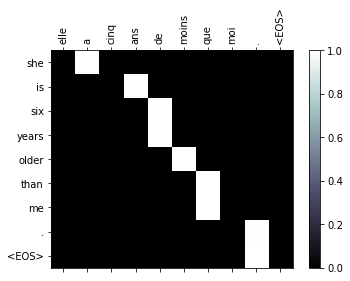

input = elle est trop petit .
output = she is too fat . <EOS>


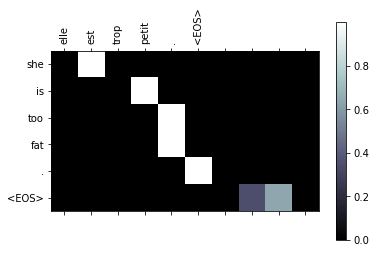

input = je ne crains pas de mourir .
output = i m not afraid to die . <EOS>


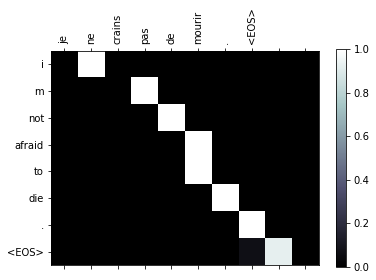

input = c est un jeune directeur plein de talent .
output = he s a lovely young young . <EOS>


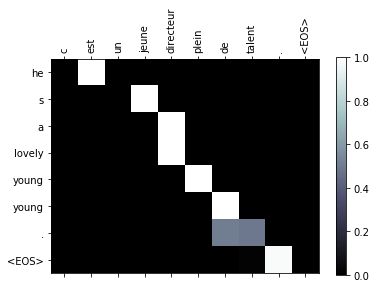

In [38]:
def showAttention(input_sentence, output_words, attentions):
    """
    Function that takes in attention and visualize the attention.
    @param - input_sentence: string the represent a list of words from source language
    @param - output_words: the gold translation in target language
    @param - attentions: a numpy array
    """
    # Set up figure with colorbar    

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # TODO: Add your code here to visualize the attention
    # look at documentation for imshow https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.matshow.html

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

Take-home Questions
---------------------
1. We used randomized initialization for word embedding. What's the advantage of using pre-trained embedding for initialization? Think about rare word.

2. Which lines of code tell the decoder to stop generate output tokens?

3. What's different in the training process when use_teacher_forcing is activated versus not activated?

4. What's the loss we used when use_teacher_forcing mode is NOT activated? Is it a reasonable loss? Why?

5. In the forward() function of AttnDecoder class, attention is computed for each output on all hidden states of source inputs. All source hidden states are stored in variable encoder_outputs. Did we directly use encoder_outputs when we compute attn_weights? If no, which variable gives information about all the source hidden states in the computation of attention weights?
